In [67]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
import seaborn as sns

from src.lif import lif_compute, spike_binary
from src.ou_process import ouprocess_gaussian
from src.spike_sync import find_synced_spikes

sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
NUM_NEURONS = 1000 # 100
tau_V = 10
R = 1 # MOhm
EL = -70.0
V_th = -40.0
dt = 0.1 # msec
t_stop = 1.0e3 # 50.0e3
tt = np.arange(0.0, t_stop, dt)
# p.dt = dt; p.tStop = t_stop; ????????
tw = 100.0

In [75]:
V = np.zeros((tt.shape[0], NUM_NEURONS)) # Membrane potential per neuron

# Additive noise to individual neurons
ETA, _ = ouprocess_gaussian(5.0, dt, t_stop, NUM_NEURONS)

In [76]:
# Slow Signal
input_slow, _ = ouprocess_gaussian(50.0, dt, t_stop, 1)
i_inj = 16.0 + 6.0*input_slow

F_binary = np.zeros((tt.shape[0], NUM_NEURONS))
avg_firing_rate = np.zeros(NUM_NEURONS)
a2 = 25.0 # pA; std of noise

I_total = a2*ETA + i_inj

for k in range(0, NUM_NEURONS):
    V[:,k] = lif_compute(I_total[:, k], R, tau_V, V_th, dt)

In [77]:
F_binary = spike_binary(V)
avg_firing_rate = np.sum(F_binary, axis=0)/(t_stop/1.0e3)

(array([  4.,  28.,  78., 160., 234., 235., 147.,  76.,  28.,  10.]),
 array([ 5.,  7.,  9., 11., 13., 15., 17., 19., 21., 23., 25.]),
 <a list of 10 Patch objects>)

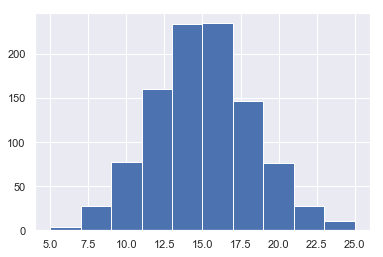

In [78]:
plt.hist(avg_firing_rate)

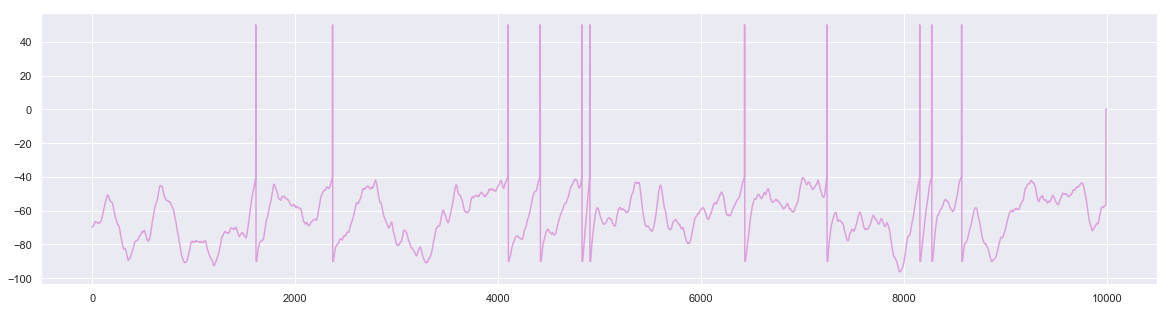

In [79]:
trial = 10
plt.figure(figsize=(20,5))
plt.plot(V[:,trial], color='plum')
# plt.plot(F_binary[:,trial] * 40.0)
plt.show()

In [80]:
F_binary.shape

(9999, 1000)

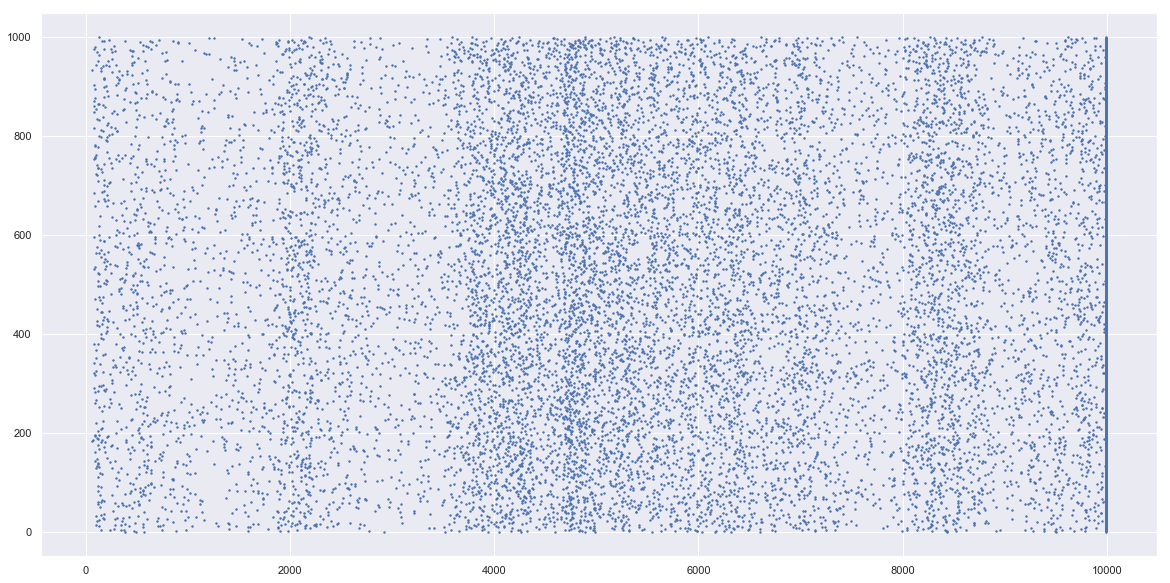

In [81]:
spike_inds, spike_trial = np.where(F_binary > 0)
plt.figure(figsize=(20,10))
plt.scatter(spike_inds, spike_trial, s=2)

In [82]:
# ind = 0*1e3/p.dt+1:10*1e3/p.dt;
# q=2;
percentage_sync = 0.5
window_sync = 5
TW = 1
psth_total = np.sum(F_binary,axis=1) # Sum of spikes from all neurons at a given t
# psth_ = psth_total(ind);
# indx_async, indx_sync, sync_event, M_S = find_synced_spikes(psth_total, percentage_sync, window_sync, TW, NUM_NEURONS, dt, t_stop)
# sig_sync = M_S;
# sig_async = not M_S;
# Sig_T{1}=sig_async(ind);
# Sig_T{2}=sig_sync(ind);
# sig_sync

In [83]:
psth_learning = psth_total
trial_num = NUM_NEURONS

min_num_spikes = percentage_sync*trial_num;
rect_kernel = np.concatenate((
    np.zeros((int(1.0/dt), 1)),
    np.ones((int(window_sync/dt), 1)),
    np.zeros((int(1.0/dt), 1))
)).flatten()
L_k = len(rect_kernel)

In [84]:
rect_kernel.shape

(70,)

In [85]:
# Rectangular kernel PSTH: total # of spikes in rectangular window
# rect_psth = np.zeros((psth_learning.shape[0]))
rect_psth = np.convolve(psth_learning, rect_kernel)
rect_psth = rect_psth[int(L_k/2):-1*int(L_k/2)]

In [86]:
psth_learning.shape

(9999,)

In [87]:
# Gaussian kernel PSTH: average # of spikes in Gaussian window
#     - used because Gaussian kernel yields smoothed graph with 1 local maxima unlike rect kernel
gaussian_psth = np.zeros((psth_learning.shape[0]))
bin_width = TW
res = dt
t = np.arange(-5.0*bin_width, 5.0*bin_width, res)

gauss_kernel = 1.0/(bin_width*np.sqrt(2.0*np.pi))*np.exp(-1.0*np.power(t, 2.0)/(2.0*np.power(bin_width, 2.0)))
gauss_kernel /= np.linalg.norm(gauss_kernel, ord=1)*res # Want area under curve to be 1

L_hkernel = gauss_kernel.shape[0]

gauss_convolved = np.convolve(psth_learning, gauss_kernel)[int(L_hkernel/2):-int(L_hkernel/2)]
gaussian_psth = gauss_convolved[:rect_psth.shape[0]]

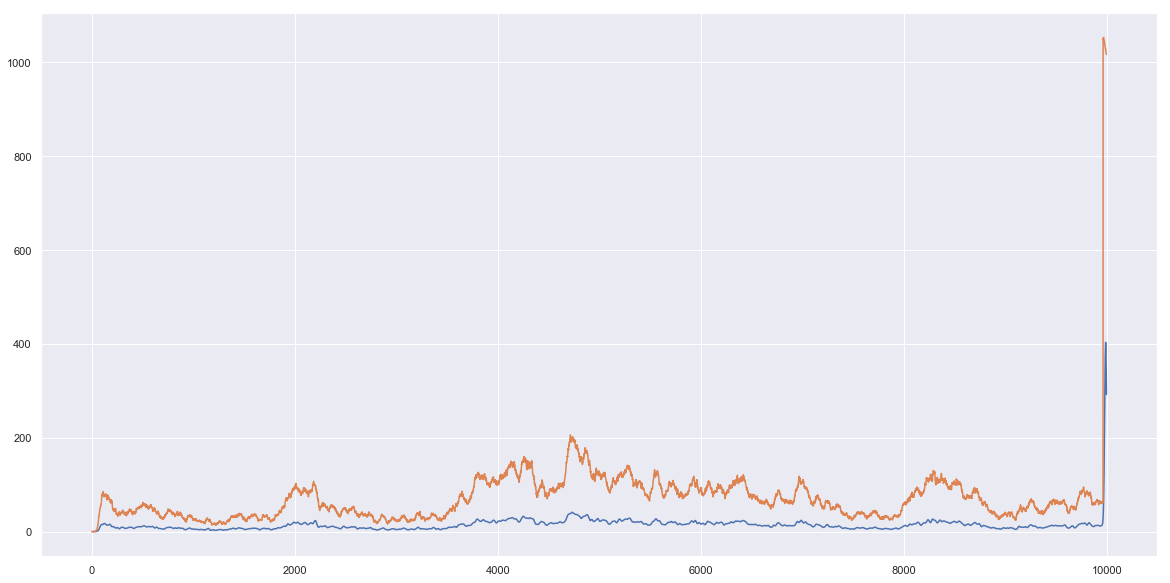

In [88]:
plt.figure(figsize=(20,10))
plt.plot(gaussian_psth)
plt.plot(rect_psth)

In [89]:
# Correcting shift between Gaussian PSTH and Rect PSTH
count = int(200/dt)
rect_psth_shifted = np.zeros(psth_learning.shape[0])
xcorr = np.correlate(
    rect_psth / np.std(rect_psth),
    gaussian_psth / np.std(gaussian_psth),
    'same'
)[int(count/2)-1:-int(count/2)] # ??????? NEED TO REVIEW
# lag_for_max = np.argmax(xcorr)
# L2 = rect_psth.shape[0] - np.abs(lag_for_max-count) + 1;
# rect_psth_shifted[:L2] = rect_psth[int(np.abs(lag_for_max-count))-1:]
rect_psth_shifted = rect_psth

(7999,)

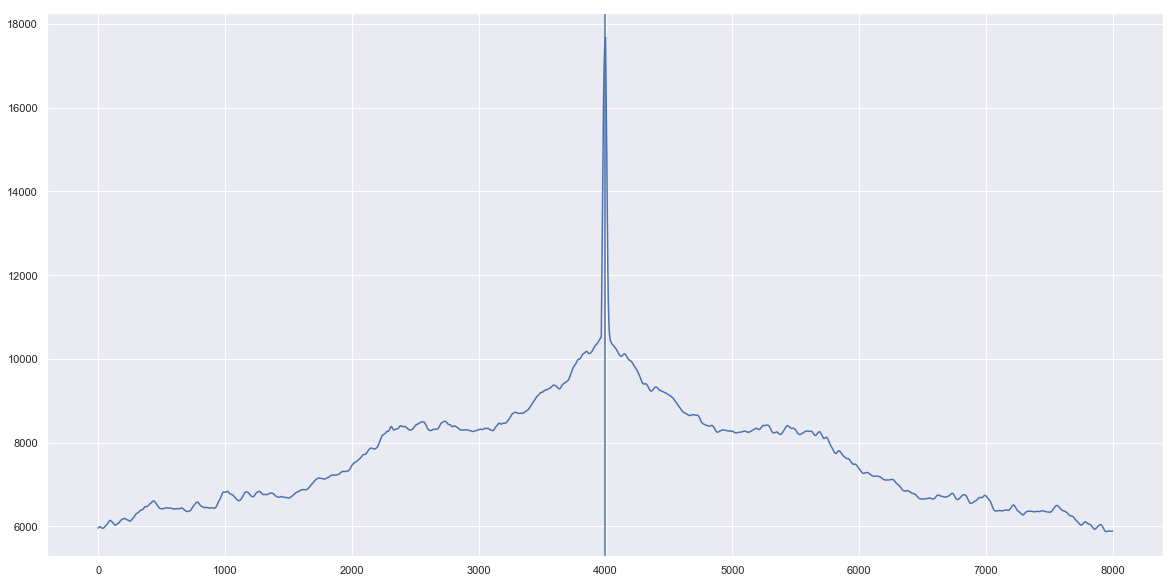

In [90]:
plt.figure(figsize=(20,10))
# plt.plot(rect_psth / np.std(rect_psth))
# plt.plot(rect_psth_shifted)
plt.plot(xcorr)
plt.axvline(int(xcorr.shape[0]/2)-1)
xcorr.shape

In [91]:
# Rescale Gaussian PSTH to represent total # of spikes
gaussian_psth_rescaled = np.divide(gaussian_psth, np.max(gaussian_psth)) * max(rect_psth_shifted)

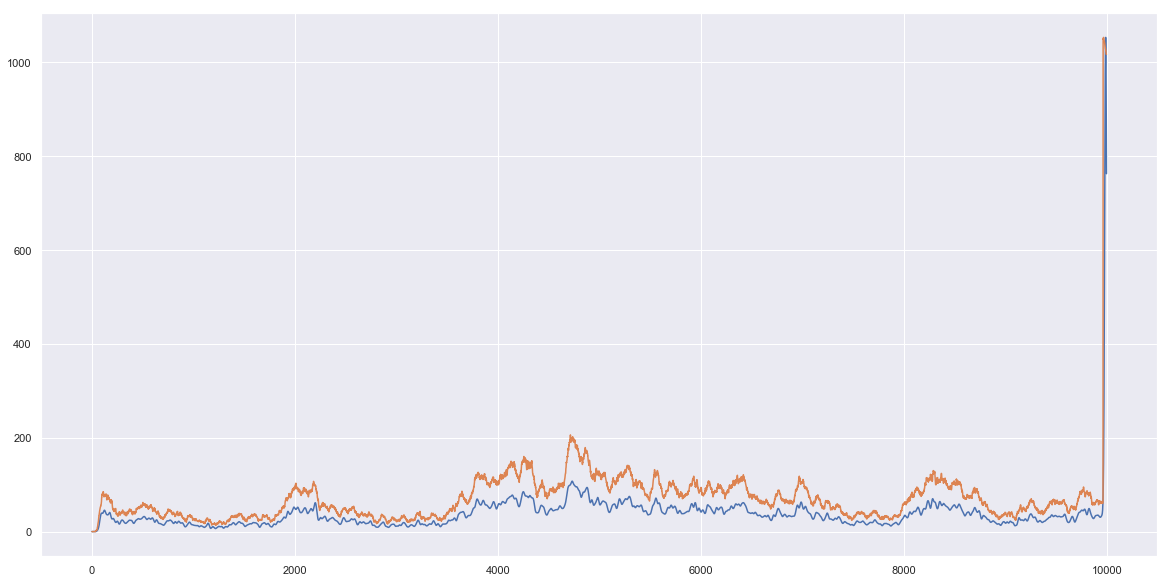

In [92]:
plt.figure(figsize=(20,10))
plt.plot(gaussian_psth_rescaled)
plt.plot(rect_psth_shifted)

In [108]:
# Find peaks
pk_inds, _ = find_peaks(gaussian_psth_rescaled)
sync_event = pk_inds[gaussian_psth_rescaled[pk_inds]>=min_num_spikes]

# Get sync spike indices, async spike indices
MM_S = np.zeros(rect_psth_shifted.shape[0])
MM_S[sync_event] = 1.0
pf = np.convolve(MM_S, rect_kernel)
M_S = pf[int(L_k/2)-1:-int(L_k/2)+1]
M_S.shape

(9999,)

In [109]:
ind_sync = np.where(psth_learning*M_S == 1.0)
ind_async = np.where((psth_learning - psth_learning*M_S) == 1.0)

# return ind_async, ind_sync, sync_event, M_S

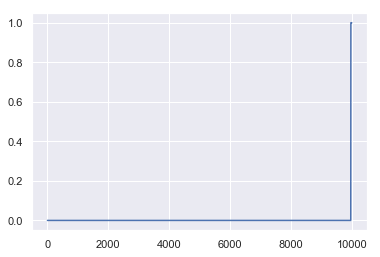

In [114]:
plt.plot(M_S)

In [12]:
# TESTING OUT VECTORIZED
k = 0
I_total = i_inj + a2*ETA[:,k]
V[:,k] = lif_compute(I_total, R, tau_V, V_th, dt)
V_selected = V[:, k, None]